# Практическая работа №4

In [ ]:
import torch
import torch.nn as nn

import torch.optim as optim
from itertools import chain

from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device, torch.cuda.get_device_name()

('cuda', 'Tesla K80')

# Часть 1. Автокодировщик. Точки на плоскости

В данной лабораторной работе вам предстоит реализовать и обучить автокодировочную нейронную сеть.

В этой части в качесте данных для обучения представляются сгенерированные точки на плоскости.

Цель в том, чтобы получить интуитивное понимание того, как автокодировщик параметризует многообразие, в окрестности которого располагаются точки в исходном признаковом пространстве.

Для этого данные сначала проебразуются обученным кодировщиком, а затем декодируются обратно в исходное пространство.

В итоге все точки лежат на параметризуемом многообразии (в данном случае, некоторой кривой на плоскости).

In [ ]:
class Encoder(nn.Module):
  # Класс кодировщика, необходимо реализовать.

  def __init__(self, inputs, latent_size):
    super().__init__()
    # ВАШ КОД ЗДЕСЬ
    self.classifier = nn.Sequential(
      nn.Linear(inputs, 256),
      nn.Linear(256, 128),
      nn.Linear(128, latent_size)
    )
    # ============

  def forward(self, x):
    return self.classifier(x)

In [ ]:
class Decoder(nn.Module):
  # Класс декодировщика, необходимо реализовать.

  def __init__(self, latent_size, outputs):
    super().__init__()
    # ВАШ КОД ЗДЕСЬ
    self.classifier = nn.Sequential(
      nn.Linear(latent_size, 128),
      nn.Linear(128, 256),
      nn.Linear(256, outputs)
    )
    # ============

  def forward(self, x):
    return self.classifier(x)

In [ ]:
def train_ae(data_loader, encoder, decoder, epochs, lr):
  # Функция для обучения автокодировщика.
  # Принимает на вход загрузчик тренеровочных данных,
  # кодировщик, декодировщик, количество эпох для обучения и скорость обучения.

  encoder.train()
  decoder.train()

  loss_history = list()

  loss_func = nn.MSELoss()  # функция потерь, нужно выбрать.
  optimizer = torch.optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=lr)  # оптимизатор, нужно выбрать.

  for epoch in range(epochs):
    for i, (batch, _) in enumerate(data_loader):
      # ВАШ КОД ЗДЕСЬ
      batch, _ = batch.to(device), _.to(device)
      optimizer.zero_grad()
      loss = loss_func(decoder(encoder(batch)), batch)  # потери на пакете, нужно вычислить.
      loss.backward()
      optimizer.step()
      # ============
      loss_history.append(loss.log().item())
    if (epoch + 1) % 10 == 0:
      print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')

  encoder.eval()
  decoder.eval()

  plt.title('Зависимость функции стоимости от номера шага градиентного спуска')
  plt.xlabel('Номер шага')
  plt.ylabel('Функция стоимости')
  plt.plot(loss_history)
  plt.show()

In [ ]:
# Создаем кодировщик и декодировщик
encoder = Encoder(2, 1).to(device)
decoder = Decoder(1, 2).to(device)

print('Архитектура кодировщика: ')
summary(encoder, [[2]])
print()
print('Архитектура декодировщика: ')
summary(decoder, [[1]])

Архитектура кодировщика: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]             768
            Linear-2                  [-1, 128]          32,896
            Linear-3                    [-1, 1]             129
Total params: 33,793
Trainable params: 33,793
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.13
Estimated Total Size (MB): 0.13
----------------------------------------------------------------

Архитектура декодировщика: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             256
            Linear-2                  [-1, 256]          33,024
            Linear-3                    [-1, 2]     

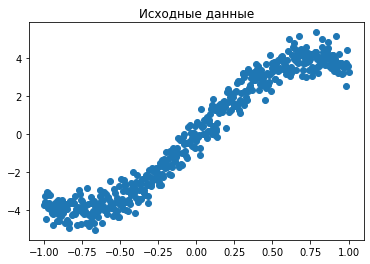

In [ ]:
# Генерируем данные
x = torch.linspace(-1, 1, steps=512)
y = 4 * torch.sin(2 * x) + torch.randn(512) / 2

plt.title('Исходные данные')
plt.scatter(x, y)
plt.show()

Эпоха 10 / 500. Потери на последнем пакете: 0.011085165664553642
Эпоха 20 / 500. Потери на последнем пакете: 0.007462130859494209
Эпоха 30 / 500. Потери на последнем пакете: 0.010456837713718414
Эпоха 40 / 500. Потери на последнем пакете: 0.009807057678699493
Эпоха 50 / 500. Потери на последнем пакете: 0.01862868294119835
Эпоха 60 / 500. Потери на последнем пакете: 0.014987541362643242
Эпоха 70 / 500. Потери на последнем пакете: 0.011238954029977322
Эпоха 80 / 500. Потери на последнем пакете: 0.007763444446027279
Эпоха 90 / 500. Потери на последнем пакете: 0.014291495084762573
Эпоха 100 / 500. Потери на последнем пакете: 0.018083736300468445
Эпоха 110 / 500. Потери на последнем пакете: 0.011859823018312454
Эпоха 120 / 500. Потери на последнем пакете: 0.010332480072975159
Эпоха 130 / 500. Потери на последнем пакете: 0.013724123127758503
Эпоха 140 / 500. Потери на последнем пакете: 0.01075834408402443
Эпоха 150 / 500. Потери на последнем пакете: 0.016224322840571404
Эпоха 160 / 500. Поте

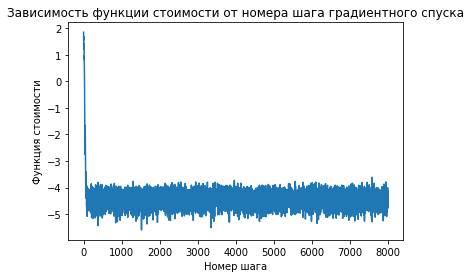

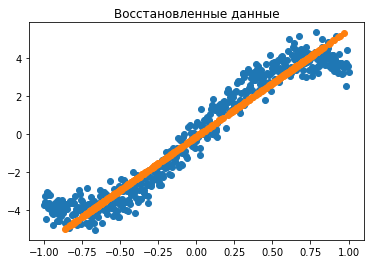

In [ ]:
# Готовим обучающие данные
train_data = torch.hstack((x.reshape(-1, 1), y.reshape(-1, 1))).to(device)
train_data_loader = DataLoader(list(zip(train_data, [torch.tensor(0)] * train_data.shape[0])), batch_size=32, shuffle=True)

# Обучаем автокодировщик
train_ae(train_data_loader, encoder, decoder, 500, 5e-5)

# Прогоняем данные через автокодировщик
restored_data = decoder(encoder(train_data))

# Отображаем результат
plt.title('Восстановленные данные')
plt.scatter(x, y)
plt.scatter(*zip(*restored_data.detach().cpu().numpy()))
plt.show()

# Часть 2. Автокодировщик. MNIST

В этой части лабораторной работы вам предстоит реализовать и обучить автокодировочную сеть на наборе данных MNIST.

Сценарий выполнения кода:
1. Обучение автокодировщика.
2. Отображение проекции скрытого пространства на плоскость для визуальной оценки распределения данных в скрытом пространстве.
3. Интерполяция между несколькими точками в скрытом пространстве, декодирование промежуточных точек в исходное пространство
и анимация результата.
4. Обучение простого классификатора на исходных данных (изображениях цифр) и на векторах в скрытом пространстве.
5. Проверка полученных классификаторов на тестовых данных.

In [ ]:
class Encoder(nn.Module):
  # Класс кодировщика, необходимо реализовать.

  def __init__(self, inputs, latent_size):
    super().__init__()
    # ВАШ КОД ЗДЕСЬ
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(inputs, 512),
      nn.Linear(512, 256),
      nn.Linear(256, 128),
      nn.Linear(128, latent_size)
    )
    # ============

  def forward(self, x):
    return self.classifier(x)


In [ ]:
class Decoder(nn.Module):
  # Класс декодировщика, необходимо реализовать.

  def __init__(self, latent_size, outputs):
    super().__init__()
    # ВАШ КОД ЗДЕСЬ
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(latent_size, 128),
      nn.Linear(128, 256),
      nn.Linear(256, 512),
      nn.Linear(512, outputs)
    )
    # ============

  def forward(self, x):
    return self.classifier(x)


In [ ]:
class SimpleClassifier(nn.Module):
  # Класс простого классификатора.
  def __init__(self, inputs, outputs):
    super().__init__()
    self.fc = nn.Linear(inputs, outputs)
    self._inputs = inputs

  def forward(self, x):
    x = x.reshape(-1, self._inputs)
    x = self.fc(x)
    return x

In [ ]:
class LatentSpaceDataset(Dataset):
  # Класс для преобразования изображений в вектора скрытого пространства.
  def __init__(self, orig_space_data_loader, encoder):
    super().__init__()
    self._data = list()
    for batch, target in orig_space_data_loader:
      latent_space_imgs = encoder(batch).detach()
      self._data.extend(zip(latent_space_imgs, target))

  def __len__(self):
    return len(self._data)

  def __getitem__(self, i):
    return self._data[i]

In [ ]:
def train_ae(data_loader, encoder, decoder, epochs, lr):
  # Функция для обучения автокодировщика.
  # Принимает на вход загрузчик тренеровочных данных,
  # кодировщик, декодировщик, количество эпох для обучения и скорость обучения.

  encoder.train()
  decoder.train()

  print('Обучение автокодировщика..')

  loss_func = nn.MSELoss()  # функция потерь, нужно выбрать.
  optimizer = torch.optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=lr)  # оптимизатор, нужно выбрать.
  loss_history = list()
  for epoch in range(epochs):
    for i, (batch, _) in enumerate(data_loader):
      # ВАШ КОД ЗДЕСЬ
      batch, _ = batch.to(device), _.to(device)
      optimizer.zero_grad()
      loss = loss_func(decoder(encoder(batch)).reshape(-1, 1, 28, 28), batch)  # потери на пакете, нужно вычислить.
      loss.backward()
      optimizer.step()
      # ============
      loss_history.append(loss.log().item())
    print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')

  print('Готово!')

  encoder.eval()
  decoder.eval()

  plt.title('Зависимость функции стоимости от номера шага градиентного спуска')
  plt.xlabel('Номер шага')
  plt.ylabel('Функция стоимости, ln')
  plt.plot(loss_history)
  plt.show()

In [ ]:
def train_classifier(data_loader, model, epochs, lr):
  # Функция для обучения классификатора.
  loss_func = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)
  model.train()
  print('Обучение классификатора..')
  for epoch in range(epochs):
    for i, (batch, target) in enumerate(data_loader):
      batch, target = batch.to(device), target.to(device)
      optimizer.zero_grad()
      loss = loss_func(model(batch), target)
      loss.backward()
      optimizer.step()
    print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')
  print('Готово!')
  model.eval()

In [ ]:
def test_classifier(data_loader, classifier):
  # Функция для тестирования классификатора.
  batch, target = next(iter(data_loader))
  print(accuracy_score(torch.argmax(classifier(batch.cpu()).cpu(), dim=1).detach().numpy(), target.cpu()))

def lerp(v1, v2, t):
  # Функция для линейной интерполяции между двумя векторами.
  return v1 * (1 - t) + v2 * t

def get_frame(i, data):
  # Функция для анимации
  i = min(i, len(data) - 1)
  ax.clear()
  ax.imshow(data[i])

In [ ]:
LATENT_SIZE = 64 # размерность скрытого пространства, можно варьировать.

BATCH_SIZE = 256
EPOCHS = 20
LEARNING_RATE = 1e-4

ANIMATION_IMAGES = 10
ANIMATION_N_FRAMES = (ANIMATION_IMAGES - 1) * 20
ANIMATION_INTERVAL = 50

In [ ]:
encoder = Encoder(28 * 28, LATENT_SIZE).to(device)
decoder = Decoder(LATENT_SIZE,  28 * 28).to(device)

print('Архитектура кодировщика: ')
summary(encoder, [[28 * 28]])
print()
print('Архитектура декодировщика: ')
summary(decoder, [[LATENT_SIZE]])

Архитектура кодировщика: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
            Linear-3                  [-1, 256]         131,328
            Linear-4                  [-1, 128]          32,896
            Linear-5                   [-1, 64]           8,256
Total params: 574,400
Trainable params: 574,400
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.19
Estimated Total Size (MB): 2.21
----------------------------------------------------------------

Архитектура декодировщика: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                   [-1, 64]   

Обучение автокодировщика..
Эпоха 1 / 20. Потери на последнем пакете: 0.03949897736310959
Эпоха 2 / 20. Потери на последнем пакете: 0.028428131714463234
Эпоха 3 / 20. Потери на последнем пакете: 0.023165803402662277
Эпоха 4 / 20. Потери на последнем пакете: 0.019096912816166878
Эпоха 5 / 20. Потери на последнем пакете: 0.018847746774554253
Эпоха 6 / 20. Потери на последнем пакете: 0.01550664659589529
Эпоха 7 / 20. Потери на последнем пакете: 0.016101766377687454
Эпоха 8 / 20. Потери на последнем пакете: 0.014442125335335732
Эпоха 9 / 20. Потери на последнем пакете: 0.013798820786178112
Эпоха 10 / 20. Потери на последнем пакете: 0.013529449701309204
Эпоха 11 / 20. Потери на последнем пакете: 0.012304503470659256
Эпоха 12 / 20. Потери на последнем пакете: 0.01193045824766159
Эпоха 13 / 20. Потери на последнем пакете: 0.010866351425647736
Эпоха 14 / 20. Потери на последнем пакете: 0.010463535785675049
Эпоха 15 / 20. Потери на последнем пакете: 0.010163887403905392
Эпоха 16 / 20. Потери на 

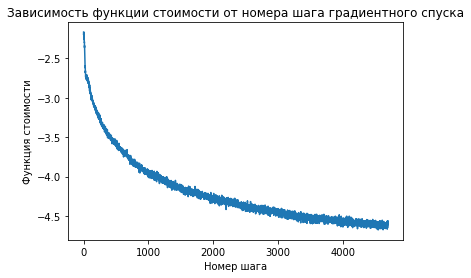

In [ ]:
train_data = MNIST('../data/MNIST/train', train=True, download=True, transform=ToTensor())
test_data = MNIST('../data/MNIST/test', train=False, download=True, transform=ToTensor())

train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

train_ae(train_data_loader, encoder, decoder, EPOCHS, LEARNING_RATE)

Проецирование скрытого пространства на плоскость..
Готово!


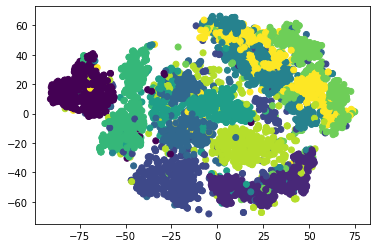

In [ ]:
test_imgs = list()
for batch, target in train_data_loader:
  test_imgs.extend(zip(batch, target))
  if len(test_imgs) > 5000:
      break
imgs_list, targets = zip(*test_imgs)
imgs = torch.stack(imgs_list).cpu()

encoder.cpu(); decoder.cpu()

print('Проецирование скрытого пространства на плоскость..')
tsne = TSNE()
latent_imgs_emb = [encoder(img.unsqueeze(0))[0].detach().numpy() for img in imgs]
latent_imgs_emb = tsne.fit_transform(np.array(latent_imgs_emb))

x, y = zip(*latent_imgs_emb)
plt.scatter(x, y, c=targets)
print('Готово!')
plt.show()

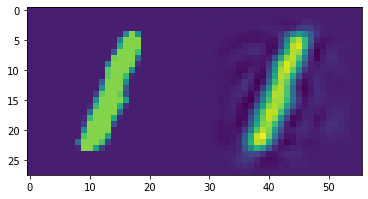

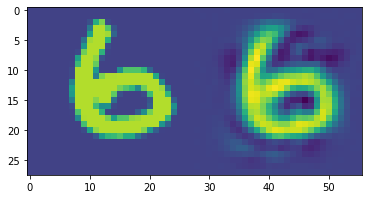

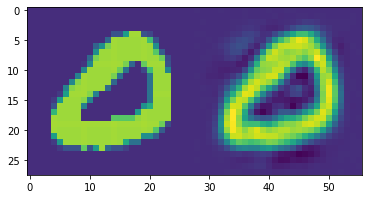

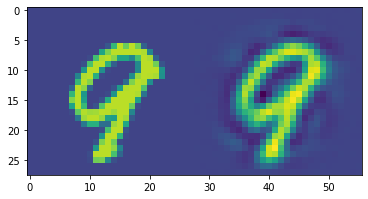

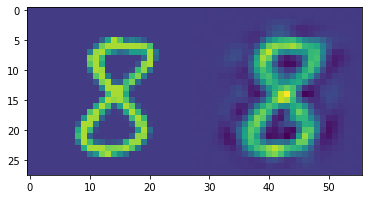

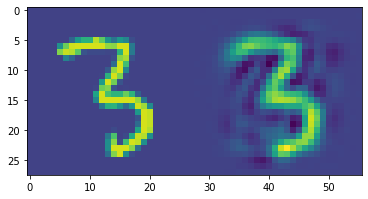

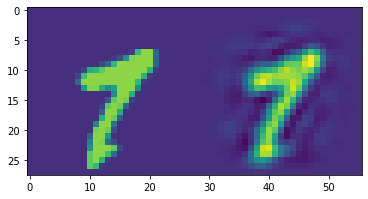

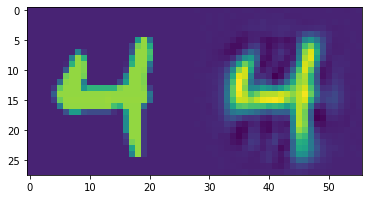

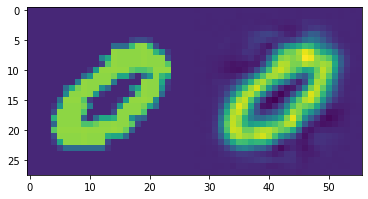

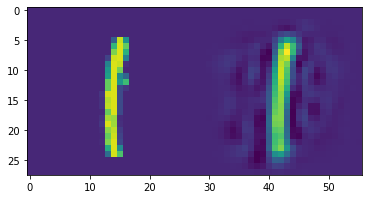

In [ ]:
latent_imgs = encoder(imgs)
restored_imgs = decoder(latent_imgs)

for i in range(ANIMATION_IMAGES):
  orig_restored = torch.hstack((imgs[i][0], restored_imgs.view(-1, 1, 28, 28)[i][0].detach()))
  plt.imshow(orig_restored.numpy())
  plt.show()

Расчет анимации..
Готово!


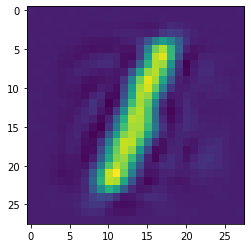

In [ ]:
print('Расчет анимации..')
figure = plt.figure()

ax = figure.add_subplot(1, 1, 1)
animation_data = list()
for i in range(50 * 20):
  frames_per_conn = ANIMATION_N_FRAMES // (ANIMATION_IMAGES - 1)
  vec_index = i // frames_per_conn
  t = i % frames_per_conn / frames_per_conn
  interp_vec = lerp(latent_imgs[vec_index], latent_imgs[vec_index + 1], t).T
  restored_img = decoder(interp_vec.resize(LATENT_SIZE, 1).T)
  animation_data.append(restored_img.view(-1, 1, 28, 28)[0][0].detach().numpy())
print('Готово!')

animation = FuncAnimation(figure, get_frame, frames=ANIMATION_N_FRAMES, interval=ANIMATION_INTERVAL, fargs=(animation_data,))
from IPython.display import HTML
HTML(animation.to_jshtml())

In [ ]:
x_classifier = SimpleClassifier(28 * 28, 10).to(device)
train_classifier(train_data_loader, x_classifier, epochs=10, lr=1e-4)

latent_space_train_data_loader = DataLoader(LatentSpaceDataset(train_data_loader, encoder), batch_size=BATCH_SIZE, shuffle=True)

z_classifier = SimpleClassifier(LATENT_SIZE, 10).to(device)
train_classifier(latent_space_train_data_loader, z_classifier, epochs=10, lr=1e-4)

Обучение классификатора..
Эпоха 1 / 10. Потери на последнем пакете: 1.550328254699707
Эпоха 2 / 10. Потери на последнем пакете: 1.0158817768096924
Эпоха 3 / 10. Потери на последнем пакете: 0.9013111591339111
Эпоха 4 / 10. Потери на последнем пакете: 0.7564175128936768
Эпоха 5 / 10. Потери на последнем пакете: 0.7343170642852783
Эпоха 6 / 10. Потери на последнем пакете: 0.6308968663215637
Эпоха 7 / 10. Потери на последнем пакете: 0.5468029379844666
Эпоха 8 / 10. Потери на последнем пакете: 0.45017239451408386
Эпоха 9 / 10. Потери на последнем пакете: 0.5014621615409851
Эпоха 10 / 10. Потери на последнем пакете: 0.552862823009491
Готово!
Обучение классификатора..
Эпоха 1 / 10. Потери на последнем пакете: 2.1553709506988525
Эпоха 2 / 10. Потери на последнем пакете: 1.9924792051315308
Эпоха 3 / 10. Потери на последнем пакете: 1.6733684539794922
Эпоха 4 / 10. Потери на последнем пакете: 1.5170561075210571
Эпоха 5 / 10. Потери на последнем пакете: 1.3552099466323853
Эпоха 6 / 10. Потери на п

In [ ]:
orig_test_data_loader = DataLoader(test_data, batch_size=1024, shuffle=True)
latent_test_data_loader = DataLoader(LatentSpaceDataset(orig_test_data_loader, encoder), batch_size=1024, shuffle=True)

test_classifier(orig_test_data_loader, x_classifier.cpu())
test_classifier(latent_test_data_loader, z_classifier.cpu())

0.892578125
0.841796875


# Часть 3. Вариационный автокодировщик. MNIST

В этой части лабораторной работы вам предстоит спроектировать, реализовать и обучить вариационный автокодировщик для генерации рукописных цифр.

Сценарий выполнения кода:
1. Обучение автокодировщика.
2. Отображение проекции скрытого пространства на плоскость для визуальной оценки распределения данных в скрытом пространстве.
3. Интерполяция между несколькими точками в скрытом пространстве, декодирование промежуточных точек в исходное пространство
и анимация результата.
4. Генерация нескольких изображений цифр.

In [ ]:
class Encoder(nn.Module):
    # Класс кодировщика, нужно реализовать.

    def __init__(self, latent_size):
        super().__init__()
        # ВАШ КОД ЗДЕСЬ

        # ============

        self.latent_size = latent_size

    def forward(self, x):
        mu = None  # модельное математическое ожидание z, нужно вычислить.
        log_var = None  # модельный логарифм дисперсии z, нужно вычислить.
        # ВАШ КОД ЗДЕСЬ

        # ============
        return mu, log_var

    def sample_latent(self, x):
        # Метод для выборки z при помощи кодировщика.
        mu, log_var = self(x)
        return torch.randn_like(mu).to(device) * torch.exp(0.5 * log_var) + mu, mu, log_var

In [ ]:
class Decoder(nn.Module):
    # Класс декодировщика, нужно реализовать.

    def __init__(self, latent_size):
        super().__init__()
        # ВАШ КОД ЗДЕСЬ

        # ============

        self.latent_size = latent_size

    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ

        # ============
        return x

In [ ]:
def train_ae(data_loader, encoder, decoder, epochs, lr, device):
    # Функция для обучения автокодировщика.
    # Принимает на вход загрузчик тренеровочных данных,
    # кодировщик, декодировщик, количество эпох для обучения, скорость обучения и устройство,
    # на котором находится автокодировщик (cpu или cuda).

    print('Обучение автокодировщика..')

    encoder.train()
    decoder.train()

    recon_loss_func = ...  # Функция потерь восстановления, нужно выбрать.
    kl_loss_func = ...  # Функция потерь похожести распределения на нормальное.
    optimizer = ...  # Оптимизатор, нужно выбрать и настроить.
    loss_history = list()

    for epoch in range(epochs):
        for i, (batch, _) in enumerate(data_loader):
            # ВАШ КОД ЗДЕСЬ
            recon_loss = recon_loss_func(...)
            kl_loss = kl_loss_func(...)
            loss = ...

            # ============
            if i % 100 == 0:
                print('Потери восстановления:', recon_loss.item())
                print('Потери расхождения распределений:', kl_loss.item())
            loss_history.append(loss.log().item())
        print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')

    encoder.eval()
    decoder.eval()

    print('Готово!')

    plt.plot(loss_history)
    plt.show()


In [ ]:
def lerp(v1, v2, t):
    # Функция для линейной интерполяции между двумя векторами.
    return v1 * (1 - t) + v2 * t


def get_frame(i, data):
    # Функция для анимации
    i = min(i, len(data) - 1)
    ax.clear()
    ax.imshow(data[i])

In [ ]:
LATENT_SIZE = 32  # размерность скрытого пространства, можно варьировать.

BATCH_SIZE = 256
EPOCHS = 15
LEARNING_RATE = 1e-4

ANIMATION_IMAGES = 5
ANIMATION_N_FRAMES = (ANIMATION_IMAGES - 1) * 20
ANIMATION_INTERVAL = 50

In [ ]:
encoder = Encoder(LATENT_SIZE).to(device)
decoder = Decoder(LATENT_SIZE).to(device)

summary(encoder, [[1, 28, 28]])
summary(decoder, [[LATENT_SIZE]])

train_data = MNIST('../data/MNIST/train', train=True, download=True, transform=ToTensor())
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

train_ae(train_data_loader, encoder, decoder, EPOCHS, LEARNING_RATE, device)

In [ ]:
test_imgs = list()
for batch, target in train_data_loader:
    test_imgs.extend(zip(batch, target))
    if len(test_imgs) > 5000:
        break
imgs_list, targets = zip(*test_imgs)
imgs = torch.stack(imgs_list).to(device)

In [ ]:
print('Проецирование скрытого пространства на плоскость..')
tsne = TSNE()
latent_imgs_emb = [encoder.sample_latent(img.unsqueeze(0))[0].cpu().detach()[0].numpy() for img in imgs]
latent_imgs_emb = tsne.fit_transform(np.array(latent_imgs_emb))
x, y = zip(*latent_imgs_emb)
plt.scatter(x, y, c=targets)
plt.show()
print('Готово!')

In [ ]:
latent_imgs = encoder(imgs)[0]
restored_imgs = decoder(latent_imgs)

for i in range(5):
    orig_restored = torch.hstack((imgs[i][0], restored_imgs[i][0].detach()))
    plt.imshow(orig_restored.cpu().numpy(), cmap='Greys')
    plt.show()

In [ ]:
print('Рассчет анимации..')
figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
animation_data = list()
for i in range(4 * 20):
    frames_per_conn = ANIMATION_N_FRAMES // (ANIMATION_IMAGES - 1)
    vec_index = i // frames_per_conn
    t = i % frames_per_conn / frames_per_conn
    interp_vec = lerp(latent_imgs[vec_index], latent_imgs[vec_index + 1], t)
    restored_img = decoder(interp_vec.unsqueeze(0))
    animation_data.append(restored_img[0][0].detach().cpu().numpy())
print('Готово!')

animation = FuncAnimation(figure, get_frame, frames=ANIMATION_N_FRAMES, interval=ANIMATION_INTERVAL, fargs=(animation_data,))
plt.show()

for _ in range(10):
    gen_latent = torch.randn(1, LATENT_SIZE, device=device)
    gen_digit = decoder(gen_latent).cpu()
    plt.imshow(gen_digit.detach()[0][0].numpy())
    plt.show()